 Basically the same as Julia's but uses the kaggle train data set and has a few changes.

In [1]:
from keras.layers import GlobalAveragePooling2D, Dense, BatchNormalization, Dropout
from keras.optimizers import Adam, SGD, RMSprop
from keras.models import Model, Input
from keras.preprocessing import image
from keras.applications import xception

import numpy as np
from sklearn import preprocessing
from keras.utils.np_utils import to_categorical

from sklearn.model_selection import train_test_split

Using TensorFlow backend.


In [2]:
# fix random seed for reproducibility
seed = 7
np.random.seed(seed)

In [3]:
# load data
X = np.load(open('Dog_images.npy','rb'))
Y = np.load(open('Dog_labels.npy','rb'))

pre_y = preprocessing.minmax_scale(Y, feature_range=(0,119))

y_cat = to_categorical(pre_y, num_classes=None)

X_train, X_test, y_train, y_test = train_test_split(X, y_cat, test_size=0.20, random_state=seed)


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:590: DataConversionWarning: Data with input dtype int64 was converted to float64.
  warnings.warn(msg, DataConversionWarning)


In [4]:
bottleneck_features = np.load('DogXceptionData.npz')
train_Xception = bottleneck_features['train']
valid_Xception = bottleneck_features['valid']
test_Xception = bottleneck_features['test']

In [5]:
def extract_Xception(tensor):
    from keras.applications.xception import Xception, preprocess_input
    return Xception(weights='imagenet', include_top=False).predict(preprocess_input(tensor))

In [6]:
NUM_CLASSES = 120
# create the base pre-trained model
base_model = xception.Xception(weights='imagenet', include_top=False)

# add a global spatial average pooling layer
x = base_model.output
#Can try adding more layers
x = BatchNormalization()(x)
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dropout(0.5)(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
# and a logistic layer -- let's say we have NUM_CLASSES classes
predictions = Dense(NUM_CLASSES, activation='softmax')(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

In [7]:
import datetime
from keras.callbacks import ModelCheckpoint
#Checkpoints still need to be added to model.fit call
# checkpoints
filepath="weights-improvement-{epoch:02d}-{loss:.4f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

In [8]:
# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional Xception layers
for layer in base_model.layers:
    layer.trainable = False

# compile the model (should be done *after* setting layers to non-trainable)
#Can try different optimizers like adam
optimizer = RMSprop(lr=0.001, rho=0.9)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=["accuracy"])

In [10]:
#train the model on the new data for a few epochs
BATCH_SIZE = 32
EPOCHS = 2

#Checkpoints still need to be added to model.fit call
model.fit(X_train, y_train, validation_data=(X_test, y_test),epochs=EPOCHS, batch_size=BATCH_SIZE)

                      
# hist = model.fit(X_train, y_train,
#                            #callbacks=[early_stopping, model_checkpoint],
#                            validation_data=(X_valid, y_valid),epochs=EPOCHS, batch_size=BATCH_SIZE,callbacks=callbacks_list)

Train on 8177 samples, validate on 2045 samples
Epoch 1/2
8177/8177 [==============================] - 2347s 287ms/step - loss: 2.0024 - acc: 0.5286 - val_loss: 15.8795 - val_acc: 0.0068
Epoch 2/2
8177/8177 [==============================] - 2265s 277ms/step - loss: 1.3850 - acc: 0.6579 - val_loss: 15.8781 - val_acc: 0.0093


In [24]:
bst_val_acc = max(hist.history['val_acc'])
print("Best val acc: {:.1%}".format(bst_val_acc))


NameError: name 'hist' is not defined

In [23]:
scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Accuracy: 0.93%


Dog Breed Predictor

In [12]:
from scipy import ndimage, io, misc
from xml.dom import minidom
from matplotlib.pyplot import imshow
import cv2           
import matplotlib.pyplot as plt  
import imageio
%matplotlib inline        
from keras.preprocessing import image
from keras.preprocessing import image                  
from tqdm import tqdm
import pandas as pd

In [13]:
#read labels.csv 
data = pd.read_csv("labels.csv") 

pic_breed = data["breed"]

#get dog names
unique_Breed = pic_breed.unique()


In [14]:
def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    print(x.shape)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

In [15]:
def detect_dog(model, image_path):
    tensor = path_to_tensor(image_path)
    print(tensor.shape)
    bottleneck_features = extract_Xception(tensor)
    print(bottleneck_features.shape)
    predicted_vector = model.predict(tensor)
    return unique_Breed[np.argmax(predicted_vector)]

In [16]:
def display_image(img_path):
    a = imageio.imread(img_path)[:,:,:3]
    imshow(a)

In [17]:
def dog_prediction(img_path): 
    #if dog_detector(img_path):    
    display_image(img_path)
    prediction = detect_dog(model, img_path)
    print('What a cute... {} ! '.format(prediction))

(224, 224, 3)
(1, 224, 224, 3)
(1, 7, 7, 2048)
What a cute... bernese_mountain_dog ! 


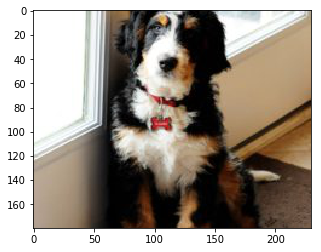

In [26]:
dog_prediction("test/n02940000_3.jpg")

(224, 224, 3)
(1, 224, 224, 3)
(1, 7, 7, 2048)
What a cute... bluetick ! 


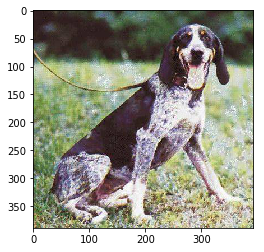

In [27]:
dog_prediction("test/4e96f8b24ad8f07d15c213c9cd59ea3b.jpg")

(224, 224, 3)
(1, 224, 224, 3)
(1, 7, 7, 2048)
What a cute... siberian_husky ! 


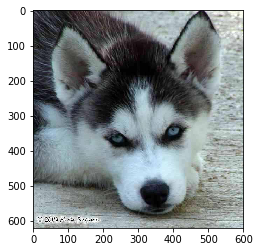

In [28]:
dog_prediction("test/15bf9b209d1e2a227028408b617822b2.jpg")

(224, 224, 3)
(1, 224, 224, 3)
(1, 7, 7, 2048)
What a cute... otterhound ! 


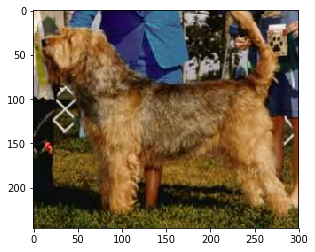

In [29]:
dog_prediction("test/f01df7641b237cd177d71fdb8db9bd58.jpg")

(224, 224, 3)
(1, 224, 224, 3)
(1, 7, 7, 2048)
What a cute... english_springer ! 


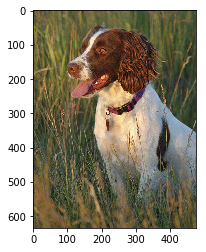

In [30]:
dog_prediction("test/00b43aa6064fa6733a391d41fe4c6803.jpg")

(224, 224, 3)
(1, 224, 224, 3)
(1, 7, 7, 2048)
What a cute... komondor ! 


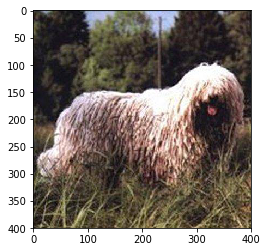

In [31]:
dog_prediction("test/79c961a446f41f6c090a2df5abab1c6b.jpg")

(224, 224, 3)
(1, 224, 224, 3)
(1, 7, 7, 2048)
What a cute... boston_bull ! 


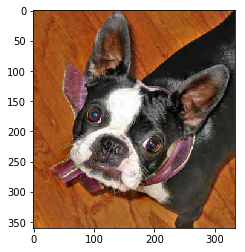

In [32]:
dog_prediction("test/fe782e941491ad736e7f05e61394822a.jpg")